In [130]:
import sklearn
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#no wrapping
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)  # Disable line-wrapping

coffea_caff_clim = pd.read_csv(r"..\data\coll_caff_node_w_class.csv")
coffea_caff_clim = pd.read_csv(r"..\data\coll_caff_node_clim_w_class.csv")
coffea_caff_env = pd.read_csv(r"..\data\coll_caff_node_env_w_class.csv")

coffee_data = coffea_caff_env.copy()

#distinct_vals = coffee_data['caffeine_class'].value_counts()
#print(distinct_vals)

coffee_data.drop(columns=['specimen_id','longitude','latitude', 'source_crs', 'mada_geom_point', 'sampled_layers', 'nodata_layers', 'is_categorical_encoded'],inplace=True)

coffee_data.head

<bound method NDFrame.head of      env_71_alt_Altitude (meters)  env_72_slo_Slope (degrees)  env_73_asp_Aspect; clockwise from North (degrees)  env_74_solrad_Solar radiation; computed from altitude, slope and aspect (Wh.m-2.day-1)  env_75_geo_Rock types (categ_vals: 1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13)  env_76_soi_Soil types (categ_vals: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23)  env_77_veg_Vegetation types (categ_vals: 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 22, 23, 25)  env_78_wat_Watersheds (categ_vals: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25)  env_79_forcov_Percentage of forest cover in 1 km by 1 km grid cells (%) caffeine_class
0                           477.0                        11.0                                              346.0                                                                                  7929.0                                                

In [131]:
headers_env = coffee_data.columns
headers_env.to_series().to_csv(r'../data/column_headers_env.csv', index=False, header=False)


In [135]:

coffee_data.columns = (coffee_data.columns
              .str.replace(r'[^\w\s]', '', regex=True)  # Remove special characters like °, parentheses, hyphen
              .str.replace(r'\s+', '_', regex=True)     # Replace spaces with underscores
              .str.strip())                             # Strip leading and trailing spaces


mapping_df = pd.read_csv(r'../data/column_mapping.csv')

mapping_df['old_name'] = (mapping_df['old_name']
                          .str.replace(r'[^\w\s]', '', regex=True)  # Clean the old names similarly
                          .str.replace(r'\s+', '_', regex=True)     # Replace spaces with underscores
                          .str.strip())
mapping_df

# Create the mapping dictionary
mapping_dict = dict(zip(mapping_df['old_name'], mapping_df['new_name']))

# Rename columns in the DataFrame using the cleaned mapping
coffee_data.rename(columns=mapping_dict, inplace=True)
coffee_data.columns

Index(['env_71_alt', 'env_72_slo', 'env_73_asp', 'env_74_solrad', 'env_75_geo', 'env_76_soi', 'env_77_veg', 'env_78_wat', 'env_79_forcov', 'caffeine_class'], dtype='object')

In [37]:
pd.set_option('display.max_rows', None)


In [136]:
missing_data = coffee_data.isnull().sum()
missing_data

env_71_alt        0
env_72_slo        0
env_73_asp        0
env_74_solrad     0
env_75_geo        0
env_76_soi        0
env_77_veg        0
env_78_wat        0
env_79_forcov     0
caffeine_class    0
dtype: int64

In [134]:
cleaned_data = coffee_data.dropna()
coffee_data = cleaned_data.copy()
coffee_data.isnull().sum()

env_71_alt                                        0
env_72_slo                                        0
env_73_asp_Aspect_clockwise_from_North_degrees    0
env_74_solrad                                     0
env_75_geo                                        0
env_76_soi                                        0
env_77_veg                                        0
env_78_wat                                        0
env_79_forcov                                     0
caffeine_class                                    0
dtype: int64

First Pass of *Random Forest cliassifier* Without Removing Correlated Features

In [137]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Assuming 'caffeine_class' is your target variable and X contains the features
X = coffee_data.drop(columns=['caffeine_class'])  # Replace with actual feature columns
y = coffee_data['caffeine_class']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)#criterion='entropy',
rf_classifier.fit(X_train, y_train)

# Get feature importance scores
feature_importances = rf_classifier.feature_importances_

# Pair feature names with their importance scores
features = X.columns
important_features = sorted(zip(features, feature_importances), key=lambda x: x[1], reverse=True)
feature_importance_dict = {feature: importance for feature, importance in zip(X.columns, feature_importances)}

# Display the most important features
for feature, importance in important_features:
    print(f"Feature: {feature}, Importance: {importance:.4f}")



Feature: env_75_geo, Importance: 0.1849
Feature: env_71_alt, Importance: 0.1509
Feature: env_78_wat, Importance: 0.1190
Feature: env_73_asp, Importance: 0.1178
Feature: env_74_solrad, Importance: 0.1104
Feature: env_76_soi, Importance: 0.0993
Feature: env_77_veg, Importance: 0.0835
Feature: env_79_forcov, Importance: 0.0776
Feature: env_72_slo, Importance: 0.0566


In [138]:
from sklearn.model_selection import cross_val_score

# Evaluate the model using cross-validation (e.g., accuracy)
scores = cross_val_score(rf_classifier, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy: ", scores.mean())


c:\Users\adm1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Cross-Validation Accuracy:  0.9322282980177719


In [139]:
# Select the top 10 important features
top_n = 10
important_features = important_features[:top_n]

# Get the feature names only (without the importance score)
important_feature_names = [feature for feature, importance in important_features]

print("Top 10 Important Features:", important_feature_names)
important_feature_names

Top 10 Important Features: ['env_75_geo', 'env_71_alt', 'env_78_wat', 'env_73_asp', 'env_74_solrad', 'env_76_soi', 'env_77_veg', 'env_79_forcov', 'env_72_slo']


['env_75_geo',
 'env_71_alt',
 'env_78_wat',
 'env_73_asp',
 'env_74_solrad',
 'env_76_soi',
 'env_77_veg',
 'env_79_forcov',
 'env_72_slo']

In [142]:
# Select features with importance greater than a threshold
threshold = 0.10  # Adjust the threshold as needed
important_features_above_threshold = [feature for feature, importance in important_features if importance > threshold]

print("Features above threshold:", important_features_above_threshold)
important_features_above_threshold

Features above threshold: ['env_75_geo', 'env_71_alt', 'env_78_wat', 'env_73_asp', 'env_74_solrad']


['env_75_geo', 'env_71_alt', 'env_78_wat', 'env_73_asp', 'env_74_solrad']

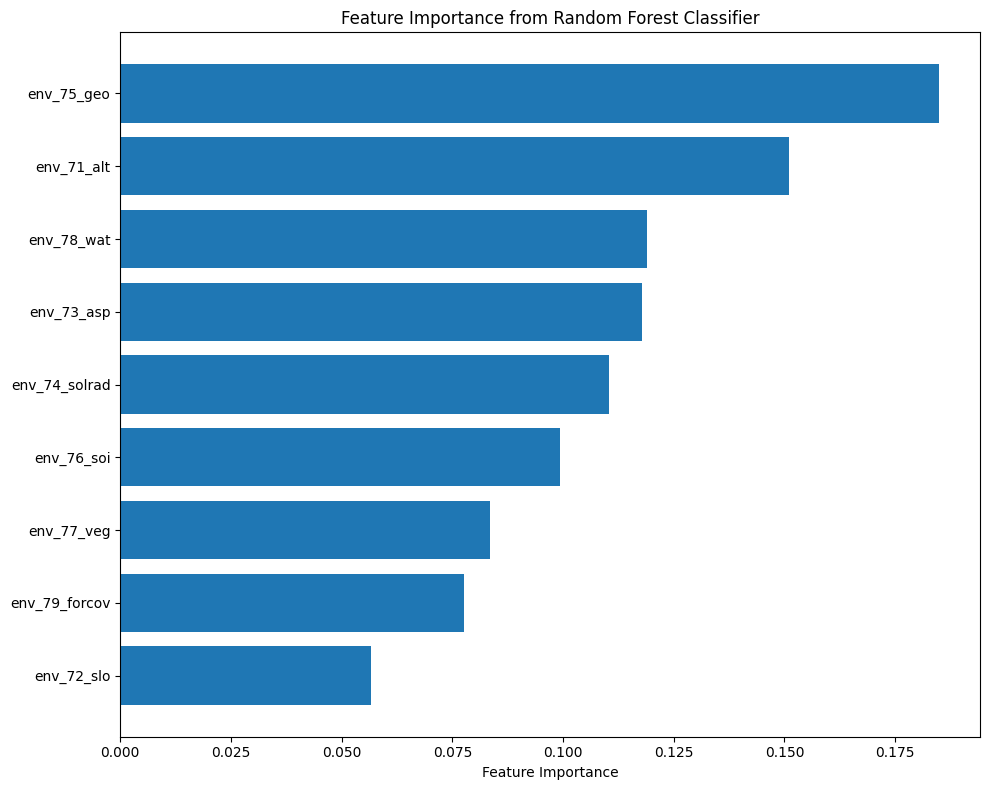

In [143]:
# Import libraries for plotting
import matplotlib.pyplot as plt
import numpy as np

# Extract the feature names and their importance scores
feature_names = [feature for feature, importance in important_features]
importances = [importance for feature, importance in important_features]

# Create a bar chart to visualize the feature importances
plt.figure(figsize=(10, 8))
plt.barh(np.arange(len(feature_names)), importances, align='center')
plt.yticks(np.arange(len(feature_names)), feature_names)
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Random Forest Classifier')
plt.gca().invert_yaxis()  # To display the most important features at the top
plt.tight_layout()
plt.show()


Using entropy

In [144]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a dataset 'coffee_data' with 'caffeine_class' as the target variable
# Split the dataset into features (X) and target variable (y)
X = coffee_data.drop(columns=['caffeine_class'])  # Features (remove the target)
y = coffee_data['caffeine_class']  # Target variable

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Classifier using 'entropy' as the criterion
rf_classifier = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Get feature importance scores
feature_importances = rf_classifier.feature_importances_

# Create a dictionary to map feature names to their importance scores
feature_importance_dict = {feature: importance for feature, importance in zip(X.columns, feature_importances)}

# Sort the features by their importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)

# Print the most informative features
print("Most Informative Features (based on entropy):")
for feature, importance in sorted_features:
    print(f"Feature: {feature}, Importance: {importance:.4f}")


Most Informative Features (based on entropy):
Feature: env_75_geo, Importance: 0.1666
Feature: env_71_alt, Importance: 0.1442
Feature: env_74_solrad, Importance: 0.1201
Feature: env_78_wat, Importance: 0.1190
Feature: env_73_asp, Importance: 0.1102
Feature: env_76_soi, Importance: 0.0981
Feature: env_79_forcov, Importance: 0.0899
Feature: env_77_veg, Importance: 0.0833
Feature: env_72_slo, Importance: 0.0686


In [145]:
from sklearn.model_selection import cross_val_score

# Evaluate the model using cross-validation (e.g., accuracy)
scores = cross_val_score(rf_classifier, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy: ", scores.mean())


c:\Users\adm1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Cross-Validation Accuracy:  0.934894053315106


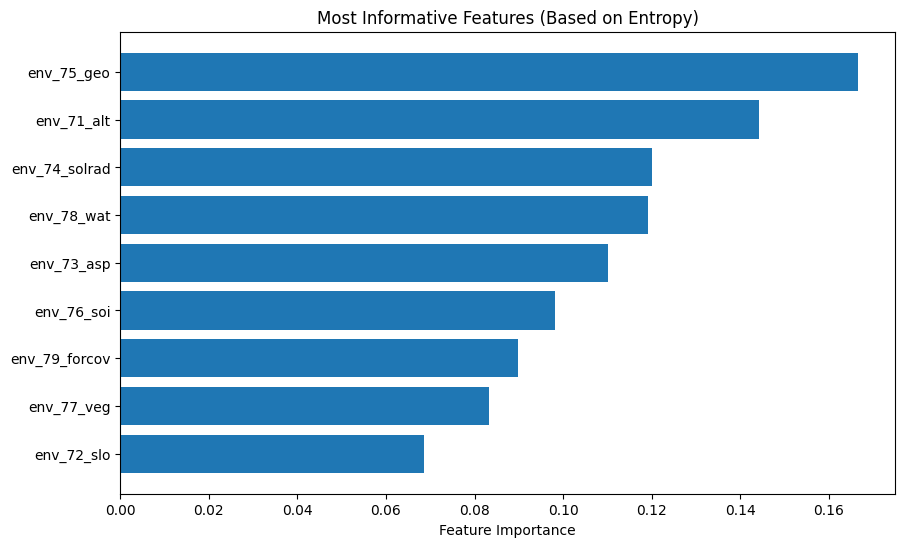

In [146]:
# Extract features and their importance for visualization
features = [feature for feature, importance in sorted_features]
importances = [importance for feature, importance in sorted_features]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(features, importances, align='center')
plt.xlabel('Feature Importance')
plt.title('Most Informative Features (Based on Entropy)')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()


Since many of the features are highly correlated, the importance of the the features can dilute feature importance scores, causing important features to seem less significant. 

Removing one feature from each highly correlated pair can lead to clearer and more accurate feature importance ranking

We will retrain the model after removing correlated features which may give us a better idea of which features are genuinely important for predicting caffeine class

In [147]:
import pandas as pd
import numpy as np

# Set the correlation threshold
threshold = 0.99

# Calculate the correlation matrix
correlation_matrix = coffee_data.drop(columns=['caffeine_class']).corr().abs()  # abs() for absolute values

# Create an empty list to store correlated pairs
correlated_pairs = []

# Create a mask to look at only the upper triangle of the correlation matrix (to avoid duplicates)
upper_triangle = np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)

# Iterate through the upper triangle and identify correlated pairs
for i in range(correlation_matrix.shape[0]):
    for j in range(i+1, correlation_matrix.shape[1]):
        if correlation_matrix.iloc[i, j] > threshold:
            feature1 = correlation_matrix.columns[i]
            feature2 = correlation_matrix.columns[j]
            correlated_pairs.append((feature1, feature2))

# Print the correlated pairs
print(correlated_pairs)
correlated_pairs


[]


[]

In [148]:
# Compare variance of correlated features
for feature1, feature2 in correlated_pairs:
    if coffee_data[feature1].var() > coffee_data[feature2].var():
        # Keep feature1, discard feature2
        print(f"Keeping {feature1}, discarding {feature2} (higher variance)")
    else:
        # Keep feature2, discard feature1
        print(f"Keeping {feature2}, discarding {feature1} (higher variance)")


In [149]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
X = coffee_data.drop(columns=['caffeine_class'])  # Assuming caffeine_class is the target variable
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


         feature        VIF
0     env_71_alt   2.909782
1     env_72_slo   3.707349
2     env_73_asp   5.191676
3  env_74_solrad  45.463255
4     env_75_geo  19.524730
5     env_76_soi  10.933024
6     env_77_veg   7.280722
7     env_78_wat   2.936223
8  env_79_forcov   3.093639


In [150]:
# Filter the vif_data DataFrame to show only rows where VIF is infinity (inf)
inf_vif_features = vif_data[vif_data['VIF'] == float('inf')]

# Display the features with VIF = inf
print(len(inf_vif_features))


0


VIF Values:
          Feature        VIF
0     env_71_alt   2.909782
1     env_72_slo   3.707349
2     env_73_asp   5.191676
3  env_74_solrad  45.463255
4     env_75_geo  19.524730
5     env_76_soi  10.933024
6     env_77_veg   7.280722
7     env_78_wat   2.936223
8  env_79_forcov   3.093639


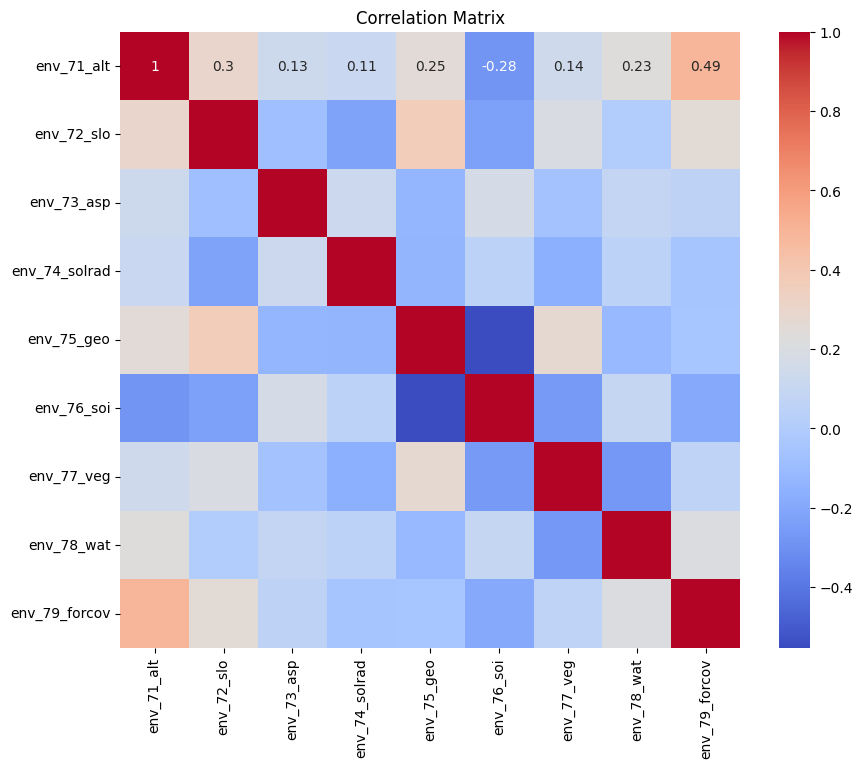

In [158]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame containing the predictor variables
X = coffee_data.drop(columns=['caffeine_class'])  # Assuming caffeine_class is the target variable

# Create a DataFrame to store VIF values
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns

# Calculate VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

print("VIF Values:\n", vif_data)

# Calculate correlation matrix
corr_matrix = X.corr()

# Visualize correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [156]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# Assuming 'df' is your DataFrame containing the predictor variables
# You may need to standardize the data first
X = coffee_data.drop(columns=['caffeine_class'])  # Assuming caffeine_class is the target variable
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a DataFrame to store VIF values
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns

# Calculate VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]

print(vif_data)


         Feature       VIF
0     env_71_alt  1.707063
1     env_72_slo  1.346065
2     env_73_asp  1.085106
3  env_74_solrad  1.150486
4     env_75_geo  1.815534
5     env_76_soi  1.620971
6     env_77_veg  1.232295
7     env_78_wat  1.208975
8  env_79_forcov  1.546068


Comparing with highly correlated features

In [151]:
import numpy as np

# Calculate the correlation matrix
correlation_matrix = coffee_data.drop(columns=['caffeine_class']).corr()

# Create a mask to get the upper triangle of the correlation matrix (to avoid duplicates)
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find features with a correlation coefficient greater than 0.9
highly_correlated_features = [column for column in upper_triangle.columns if any(upper_triangle[column].abs() > 0.9)]

highly_correlated_features

[]

In [103]:
len(highly_correlated_features)

57

In [159]:
# Drop the highly correlated features
reduced_data = coffee_data.drop(columns=highly_correlated_features)

# Display the reduced dataset shape
print(f"Original dataset shape: {coffee_data.shape}")
print(f"Reduced dataset shape (after removing highly correlated features): {reduced_data.shape}")


Original dataset shape: (480, 10)
Reduced dataset shape (after removing highly correlated features): (480, 10)


In [160]:

reduced_data = coffee_data.drop(columns=highly_correlated_features)
reduced_data.to_csv(r'../data/reduced_data.csv')
# Display the reduced dataset shape
print(f"Original dataset shape: {coffee_data.shape}")
print(f"Reduced dataset shape (after removing highly correlated features): {reduced_data.shape}")

Original dataset shape: (480, 10)
Reduced dataset shape (after removing highly correlated features): (480, 10)


Once highly correlated values have been removed we try reclassifying features

In [161]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Assuming 'caffeine_class' is your target variable and X contains the features
X = reduced_data.drop(columns=['caffeine_class'])  # Replace with actual feature columns
y = reduced_data['caffeine_class']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)#criterion='entropy',
rf_classifier.fit(X_train, y_train)

# Get feature importance scores
feature_importances = rf_classifier.feature_importances_

# Pair feature names with their importance scores
features = X.columns
important_features = sorted(zip(features, feature_importances), key=lambda x: x[1], reverse=True)
feature_importance_dict = {feature: importance for feature, importance in zip(X.columns, feature_importances)}

# Display the most important features
for feature, importance in important_features:
    print(f"Feature: {feature}, Importance: {importance:.4f}")



Feature: env_75_geo, Importance: 0.1849
Feature: env_71_alt, Importance: 0.1509
Feature: env_78_wat, Importance: 0.1190
Feature: env_73_asp, Importance: 0.1178
Feature: env_74_solrad, Importance: 0.1104
Feature: env_76_soi, Importance: 0.0993
Feature: env_77_veg, Importance: 0.0835
Feature: env_79_forcov, Importance: 0.0776
Feature: env_72_slo, Importance: 0.0566


In [121]:
# Calculate the correlation matrix
correlation_matrix = reduced_data.drop(columns=['caffeine_class']).corr()

# Create a mask to get the upper triangle of the correlation matrix (to avoid duplicates)
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find features with a correlation coefficient greater than 0.9
highly_correlated_features = [column for column in upper_triangle.columns if any(upper_triangle[column].abs() > 0.9)]

highly_correlated_features

[]

In [122]:
from sklearn.model_selection import cross_val_score

# Evaluate the model using cross-validation (e.g., accuracy)
scores = cross_val_score(rf_classifier, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy: ", scores.mean())


c:\Users\adm1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Cross-Validation Accuracy:  0.9248016456068175


c:\Users\adm1\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\adm1\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\adm1\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\adm1\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: us

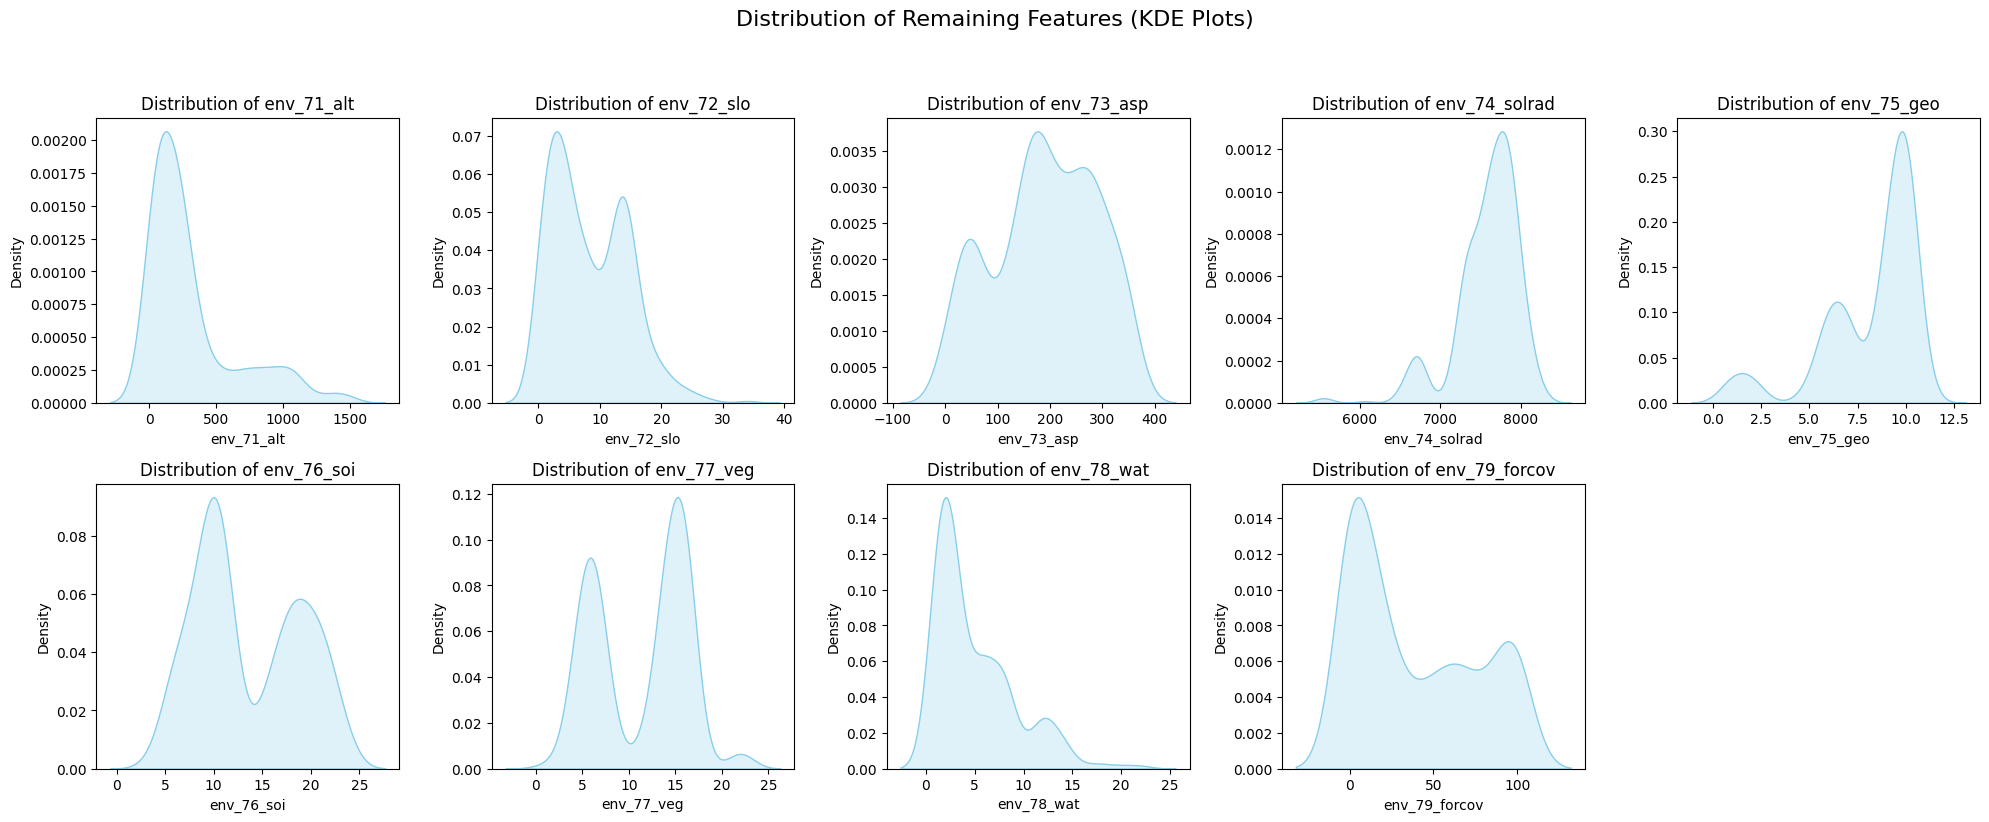

In [162]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'reduced_data' contains the 13 remaining attributes

X_data = reduced_data.drop(columns=['caffeine_class'])
# List of remaining features
remaining_features = X_data.columns  # Adjust if needed

# Create a 3x5 subplot layout (to accommodate 13 features)
rows = 3
cols = 5
fig, axes = plt.subplots(rows, cols, figsize=(20, 12))
fig.suptitle('Distribution of Remaining Features (KDE Plots)', fontsize=16)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot each feature in the corresponding subplot
for i, feature in enumerate(remaining_features):
    sns.kdeplot(data=reduced_data[feature], ax=axes[i], fill=True, color='skyblue')
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Density')

# Remove unused subplots if there are fewer features than subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])  # Delete unused axes

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the title
plt.show()


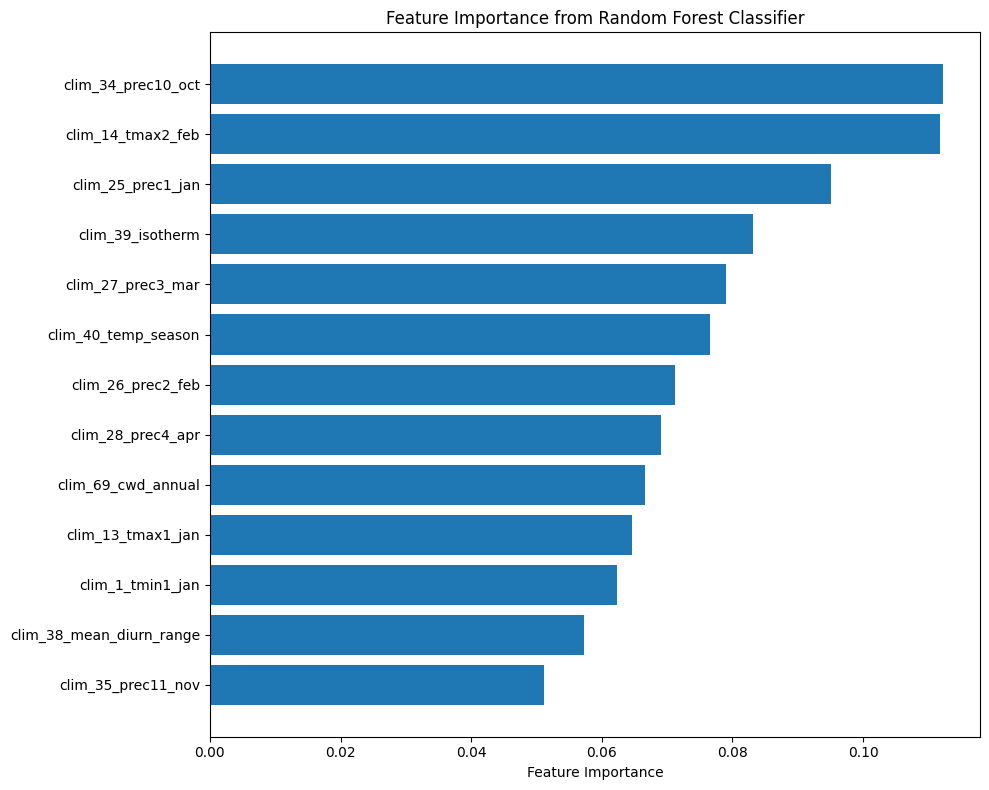

In [123]:
# Import libraries for plotting
import matplotlib.pyplot as plt
import numpy as np

# Extract the feature names and their importance scores
feature_names = [feature for feature, importance in important_features]
importances = [importance for feature, importance in important_features]

# Create a bar chart to visualize the feature importances
plt.figure(figsize=(10, 8))
plt.barh(np.arange(len(feature_names)), importances, align='center')
plt.yticks(np.arange(len(feature_names)), feature_names)
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Random Forest Classifier')
plt.gca().invert_yaxis()  # To display the most important features at the top
plt.tight_layout()
plt.show()

c:\Users\adm1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Cross-Validation Scores:  [0.89156627 0.93975904 0.91463415 0.96341463 0.91463415]
Mean Accuracy:  0.9248016456068175
Standard Deviation of Accuracy:  0.024600947210829966


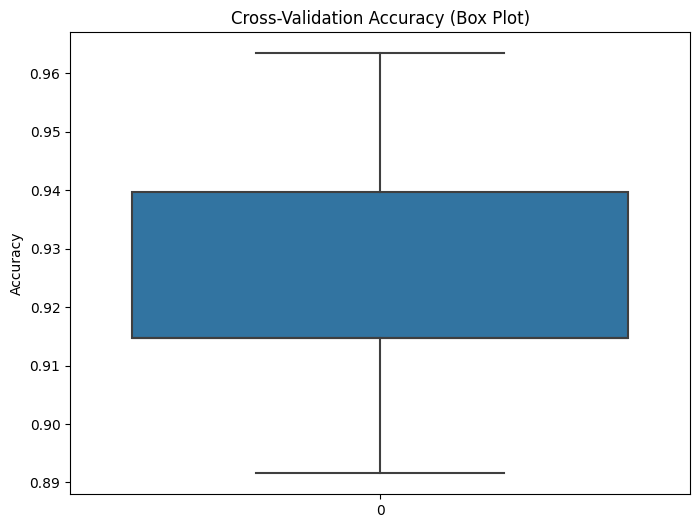

c:\Users\adm1\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


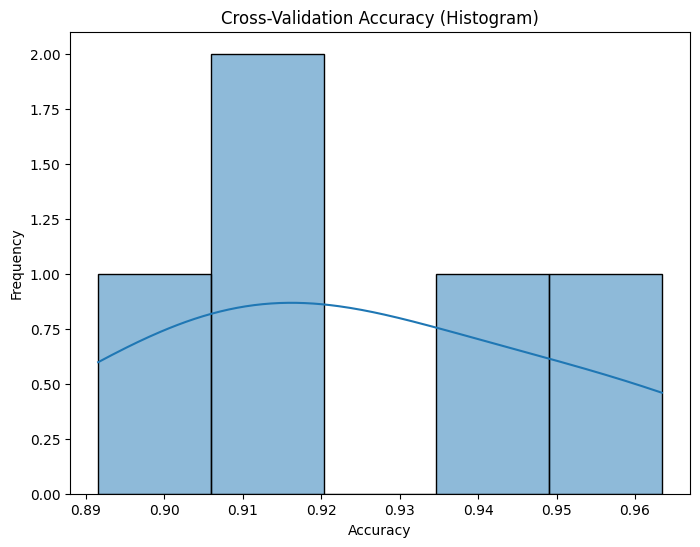

In [124]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'rf_classifier' is your trained RandomForestClassifier
# and 'X_train' and 'y_train' are your feature and target datasets

# Run cross-validation to compute accuracy for each fold
cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv=5, scoring='accuracy')

# Print the cross-validation scores
print("Cross-Validation Scores: ", cv_scores)
print("Mean Accuracy: ", cv_scores.mean())
print("Standard Deviation of Accuracy: ", cv_scores.std())

# Visualization 1: Box Plot of Cross-Validation Scores
plt.figure(figsize=(8, 6))
sns.boxplot(data=cv_scores)
plt.title('Cross-Validation Accuracy (Box Plot)')
plt.ylabel('Accuracy')
plt.show()

# Visualization 2: Histogram of Cross-Validation Scores
plt.figure(figsize=(8, 6))
sns.histplot(cv_scores, bins=5, kde=True)
plt.title('Cross-Validation Accuracy (Histogram)')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.show()


In [125]:
# Run cross-validation to compute accuracy for each fold
cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv=5, scoring='accuracy')

print("Cross-Validation Accuracy Scores: ", cv_scores)


c:\Users\adm1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Cross-Validation Accuracy Scores:  [0.89156627 0.93975904 0.91463415 0.96341463 0.91463415]


In [126]:
from sklearn.model_selection import cross_val_score

# Use F1 score for multiclass classification (with weighted average)
cv_f1_scores = cross_val_score(rf_classifier, X_train, y_train, cv=5, scoring='f1_weighted')

print("Cross-Validation F1 Scores (weighted): ", cv_f1_scores)
print("Mean F1 Score: ", cv_f1_scores.mean())


c:\Users\adm1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Cross-Validation F1 Scores (weighted):  [0.88289157 0.93398387 0.91404432 0.96316185 0.91116399]
Mean F1 Score:  0.9210491184670271


In [127]:
# Use precision score for multiclass classification (with macro average)
cv_precision_scores = cross_val_score(rf_classifier, X_train, y_train, cv=5, scoring='precision_macro')

# Use recall score for multiclass classification (with macro average)
cv_recall_scores = cross_val_score(rf_classifier, X_train, y_train, cv=5, scoring='recall_macro')

print("Cross-Validation Precision Scores (macro): ", cv_precision_scores)
print("Cross-Validation Recall Scores (macro): ", cv_recall_scores)


c:\Users\adm1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\adm1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\adm1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\adm1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn

Cross-Validation Precision Scores (macro):  [0.59373219 0.61997019 0.89848485 0.96060606 0.92534722]
Cross-Validation Recall Scores (macro):  [0.56464646 0.62525253 0.88761975 0.94804716 0.86109064]
